In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from glob import glob

In [ ]:
# !ls "/content/drive/My Drive"

In [23]:
os.listdir()

['o3', 'data', 'ML-project-Preliminaries.gdoc', 'prophet.ipynb', 'LSTM.ipynb']

In [25]:
import os

# Print current working directory
print("Current Working Directory: ", os.getcwd())

# Try to list contents of the current directory or a known directory
print("Contents of the current directory: ", os.listdir())

# Use an absolute path (modify this according to your file system)
absolute_path = '/path/to/drive/MyDrive/ML-project'

# Check if the path exists
if os.path.exists(absolute_path):
    os.chdir(absolute_path)
    print("Changed directory to: ", os.getcwd())
    print("Contents of ML-project directory: ", os.listdir())
else:
    print("Directory not found: ", absolute_path)


Current Working Directory:  /content/drive/.shortcut-targets-by-id/1TXiJHdcw3NpU4djnyH6iRTWY2sTP877t/ML-project
Contents of the current directory:  ['o3', 'data', 'ML-project-Preliminaries.gdoc', 'prophet.ipynb', 'LSTM.ipynb']
Directory not found:  /path/to/drive/MyDrive/ML-project


In [24]:
os.chdir('drive/MyDrive/ML-project')
os.listdir()

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/ML-project'

# LSTM - PyTorch

In [28]:
df=pd.read_csv('data/train_imputed.csv')
val=pd.read_csv('data/validation_imputed.csv')
df.head(), val.head()

(                  time     o3  wind  temp   no2   no   nox  objectid  year  \
 0  2021-07-01 00:00:00  124.7   3.1  12.9  13.3  0.5  14.0      4348  2021   
 1  2021-07-01 01:00:00  124.7   3.0  12.7   9.7  0.1   9.9      4349  2021   
 2  2021-07-01 02:00:00  124.7   2.9  12.5   7.6  0.1   7.7      4350  2021   
 3  2021-07-01 03:00:00  124.7   3.2  12.6   9.0  0.0   9.1      4351  2021   
 4  2021-07-01 04:00:00  124.7   2.6  12.1  11.0  0.2  11.5      4352  2021   
 
    month  ...  hday_lundi_de_pentecôte  hday_fête_nationale  hday_assomption  \
 0      7  ...                        0                    0                0   
 1      7  ...                        0                    0                0   
 2      7  ...                        0                    0                0   
 3      7  ...                        0                    0                0   
 4      7  ...                        0                    0                0   
 
    hday_toussaint  hday_armistice  

In [29]:
timeseries=pd.concat([df,val], ignore_index=True)[["no2"]].values.astype('float32')
train_size=len(train)

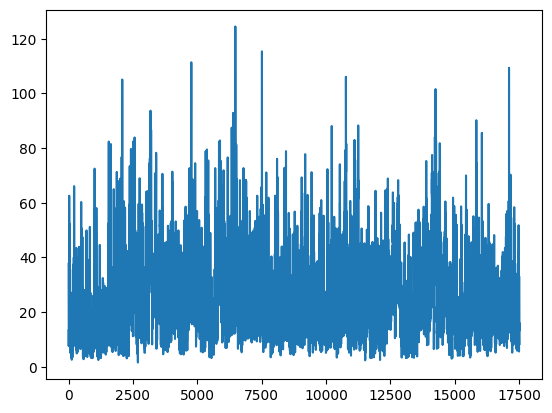

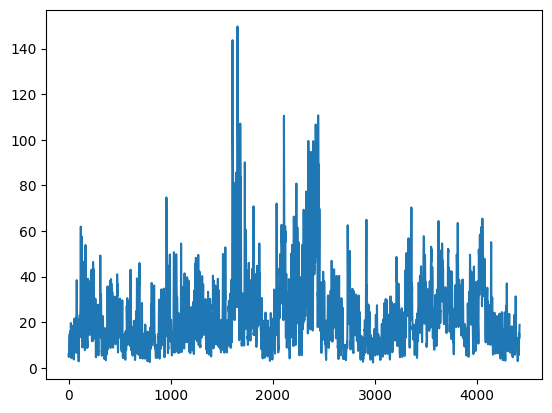

In [30]:
train = df[["no2"]].values.astype('float32')
test = val[["no2"]].values.astype('float32')
plt.plot(train)
plt.show()

plt.plot(test)
plt.show()

In [31]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [32]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([17519, 1, 1]) torch.Size([17519, 1, 1])
torch.Size([4415, 1, 1]) torch.Size([4415, 1, 1])


In [33]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
        # #  Since the output from LSTM is one per each input time step, you can chooce to pick only the last timestep’s output:
        # x, _ = self.lstm(x)
        # # extract only the last time step
        # x = x[:, -1, :]
        # x = self.linear(x)

In [ ]:
#TRAINING
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 50 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 7.9780, test RMSE 9.6640


In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()